In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
sns.set()
import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['glaucoma-detection']


In [2]:

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [3]:
df= pd.read_csv('/kaggle/input/glaucoma-detection/glaucoma.csv')
y_train = df['Glaucoma']
df.head()

Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0
3  004.jpg  0.7246  OD   A         0
4  005.jpg  0.6138  OS   A         0

In [4]:
df['eye'] = df['Eye'].map({'OD': 0, 'OS': 1})
df['set'] = df['Set'].map({'A':0, 'B':1})
df['image'] = np.nan
df['image_file']=np.nan

In [5]:
df.head()

Filename  ExpCDR Eye Set  Glaucoma  eye  set  image  image_file
0  001.jpg  0.7097  OD   A         0    0    0    NaN         NaN
1  002.jpg  0.6953  OS   A         0    1    0    NaN         NaN
2  003.jpg  0.9629  OS   A         0    1    0    NaN         NaN
3  004.jpg  0.7246  OD   A         0    0    0    NaN         NaN
4  005.jpg  0.6138  OS   A         0    1    0    NaN         NaN

In [6]:
image_dir = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted'

In [7]:
train_dir = os.path.join(image_dir, 'Train')
validation_dir = os.path.join(image_dir, 'Validation')

In [8]:
mapping = {
    0: 'Glaucoma_Negative',
    1: 'Glaucoma_Positive'
}

In [9]:
from skimage.io import imread
from skimage.transform import resize

In [10]:
train_image_negative = os.listdir(os.path.join(train_dir, 'Glaucoma_Negative'))
train_image_positive = os.listdir(os.path.join(train_dir, 'Glaucoma_Positive'))
print(len(train_image_negative) + len(train_image_positive))

520


In [11]:
test_image_negative = os.listdir(os.path.join(validation_dir, 'Glaucoma_Negative'))
test_image_positive = os.listdir(os.path.join(validation_dir, 'Glaucoma_Positive'))
print(len(test_image_negative) + len(test_image_positive))

130


In [12]:
df_train = df[df['Filename'].isin(train_image_negative) | df['Filename'].isin(train_image_positive)]
df_train

Filename  ExpCDR Eye Set  Glaucoma  eye  set  image  image_file
0    001.jpg  0.7097  OD   A         0    0    0    NaN         NaN
1    002.jpg  0.6953  OS   A         0    1    0    NaN         NaN
2    003.jpg  0.9629  OS   A         0    1    0    NaN         NaN
3    004.jpg  0.7246  OD   A         0    0    0    NaN         NaN
4    005.jpg  0.6138  OS   A         0    1    0    NaN         NaN
..       ...     ...  ..  ..       ...  ...  ...    ...         ...
588  589.jpg  0.8282  OD   A         1    0    0    NaN         NaN
590  591.jpg  0.6424  OS   B         1    1    1    NaN         NaN
591  592.jpg  0.7105  OD   A         1    0    0    NaN         NaN
592  593.jpg  0.6456  OS   A         1    1    0    NaN         NaN
594  595.jpg  0.5995  OD   B         1    0    1    NaN         NaN

[520 rows x 9 columns]

In [13]:
df_test = df[df['Filename'].isin(test_image_negative) | df['Filename'].isin(test_image_positive)]
len(df_test)

130

In [14]:
df_train['Glaucoma'].value_counts()

0    386
1    134
Name: Glaucoma, dtype: int64

In [15]:
IMAGE_SIZE = (224,224)

In [16]:
def load_image_file(row):
    global count
    folder_name = mapping[row['Glaucoma']]
    folder_path = os.path.join(train_dir, folder_name)
    image_path = os.path.join(folder_path, row['Filename'])
    return image_path

In [17]:
df_train['image_file']=df_train.apply(load_image_file, axis=1)

In [18]:
def load_image(row):
    global count
    folder_name = mapping[row['Glaucoma']]
    folder_path = os.path.join(train_dir, folder_name)
    image_path = os.path.join(folder_path, row['Filename'])
    im = imread(image_path)
    im = resize(im, IMAGE_SIZE)
    print(image_path)
    return im

In [19]:
df_train['image'] = df_train.apply(load_image, axis=1)


/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg
/kaggle/input/glaucoma-detec

In [20]:
def load_image1(row):
    global count
    folder_name = mapping[row['Glaucoma']]
    folder_path = os.path.join(validation_dir, folder_name)
    image_path = os.path.join(folder_path, row['Filename'])
    im = imread(image_path)
    im = resize(im, IMAGE_SIZE)
    print(image_path)
    return im

In [21]:
def load_image_file1(row):
    global count
    folder_name = mapping[row['Glaucoma']]
    folder_path = os.path.join(validation_dir, folder_name)
    image_path = os.path.join(folder_path, row['Filename'])
    return image_path

In [22]:
df_test['image_file'] = df_test.apply(load_image_file1, axis=1)

In [23]:
df_test['image'] = df_test.apply(load_image1, axis=1)


/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/483.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/484.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/485.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/487.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/488.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/491.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/492.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_

In [24]:
df_train.head()

Filename  ExpCDR Eye Set  Glaucoma  eye  set  \
0  001.jpg  0.7097  OD   A         0    0    0   
1  002.jpg  0.6953  OS   A         0    1    0   
2  003.jpg  0.9629  OS   A         0    1    0   
3  004.jpg  0.7246  OD   A         0    0    0   
4  005.jpg  0.6138  OS   A         0    1    0   

                                               image  \
0  [[[0.0017253220843557503, 0.008973885980484157...   
1  [[[0.003625756526244185, 0.004218782766785775,...   
2  [[[0.002288547487037265, 0.00953560492300856, ...   
3  [[[0.001973991291448104, 0.009222554997021522,...   
4  [[[0.003521468954652978, 0.0035215460052506003...   

                                          image_file  
0  /kaggle/input/glaucoma-detection/Fundus_Train_...  
1  /kaggle/input/glaucoma-detection/Fundus_Train_...  
2  /kaggle/input/glaucoma-detection/Fundus_Train_...  
3  /kaggle/input/glaucoma-detection/Fundus_Train_...  
4  /kaggle/input/glaucoma-detection/Fundus_Train_...

In [25]:
df_test.head()

Filename  ExpCDR Eye Set  Glaucoma  eye  set  \
482  483.jpg  0.4803  OS   A         0    1    0   
483  484.jpg  0.4529  OD   B         0    0    1   
484  485.jpg  0.3976  OS   B         0    1    1   
486  487.jpg  0.6659  OS   B         0    1    1   
487  488.jpg  0.6364  OD   A         0    0    0   

                                                 image  \
482  [[[0.0057709501720112875, 0.005770950076733795...   
483  [[[0.0036476558263308567, 0.003647655826330856...   
484  [[[0.005346717992144828, 0.005346717992144828,...   
486  [[[0.002243290752095683, 0.0022577448446773076...   
487  [[[0.0037924282660345807, 0.003793898524223909...   

                                            image_file  
482  /kaggle/input/glaucoma-detection/Fundus_Train_...  
483  /kaggle/input/glaucoma-detection/Fundus_Train_...  
484  /kaggle/input/glaucoma-detection/Fundus_Train_...  
486  /kaggle/input/glaucoma-detection/Fundus_Train_...  
487  /kaggle/input/glaucoma-detection/Fundus_Train_...

CPU times: user 320 ms, sys: 66.4 ms, total: 387 ms
Wall time: 327 ms


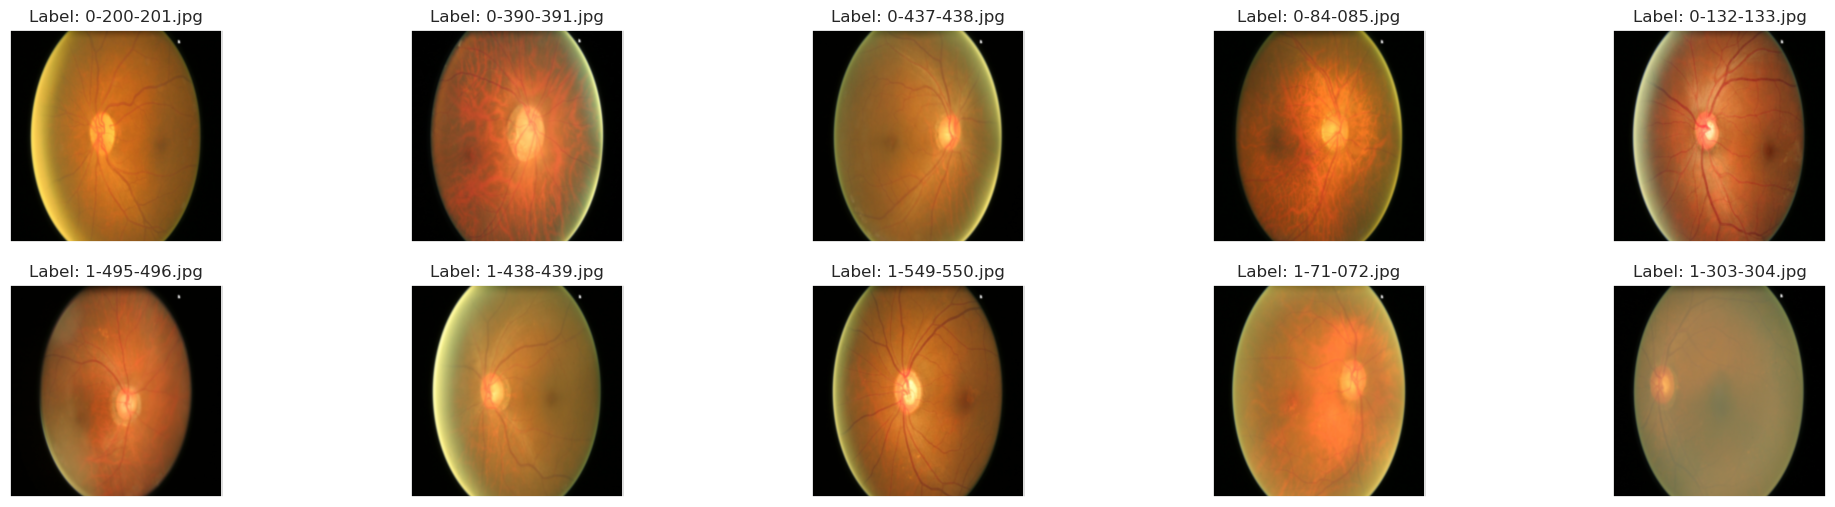

In [26]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(df_train['Glaucoma'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['Glaucoma'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        image = np.float32(row['image'])
        image = cv2.cvtColor(image, 0)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['Filename']) )

CPU times: user 299 ms, sys: 33.9 ms, total: 333 ms
Wall time: 253 ms


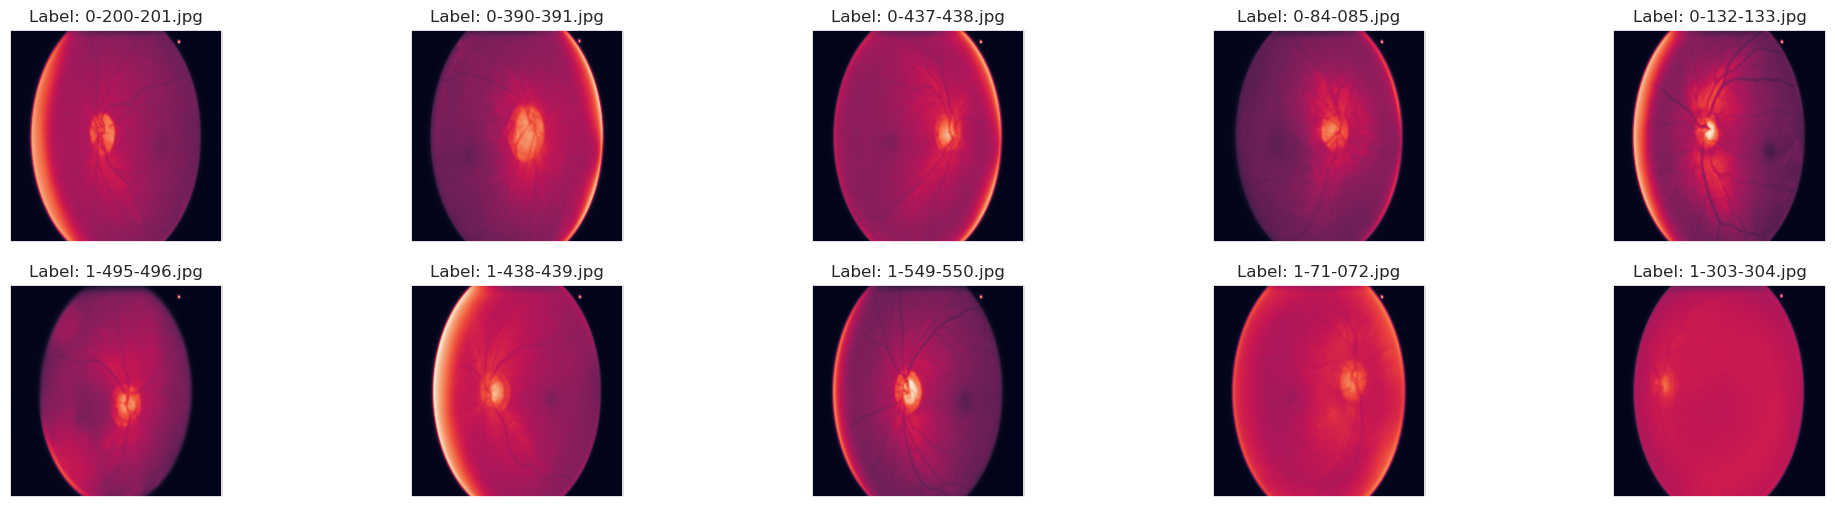

In [27]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(df_train['Glaucoma'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['Glaucoma'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        image = np.float32(row['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['Filename']) )

CPU times: user 682 ms, sys: 32.8 ms, total: 715 ms
Wall time: 647 ms


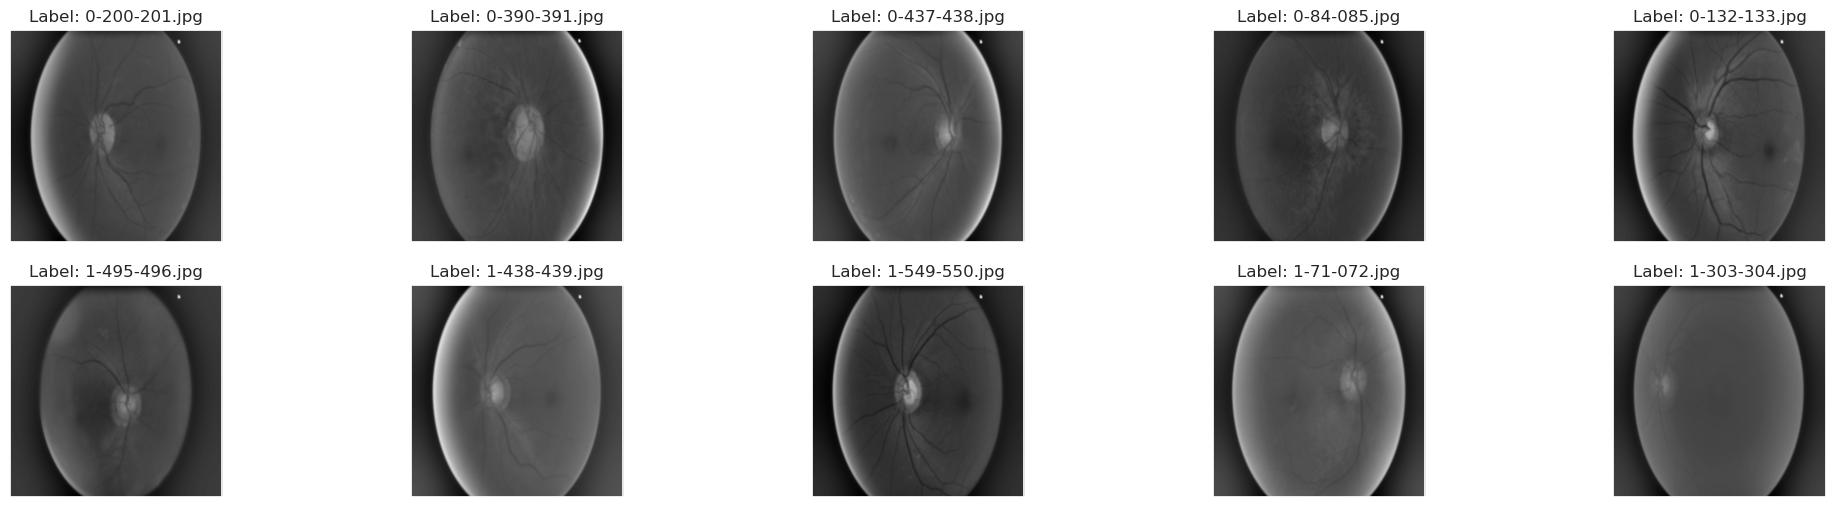

In [28]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(df_train['Glaucoma'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['Glaucoma'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        image = np.float32(row['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['Filename']) )

In [29]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [30]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

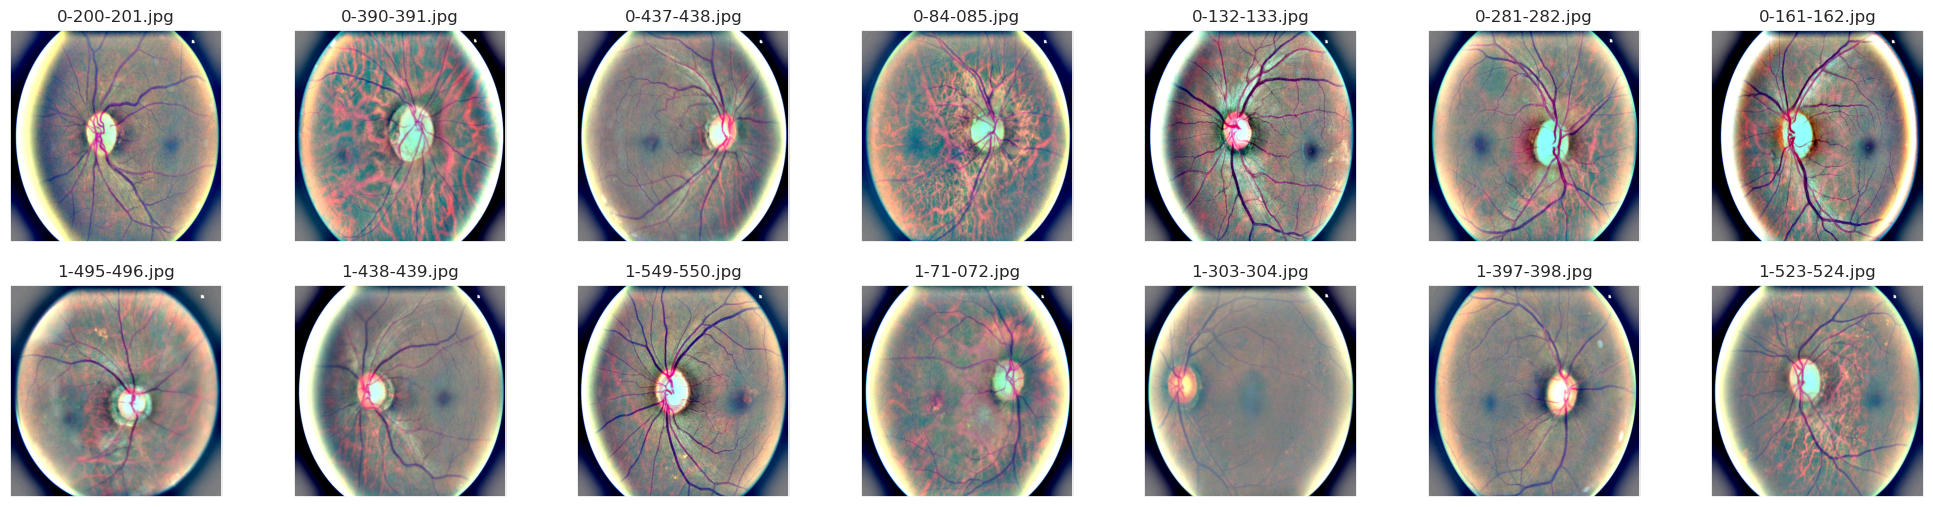

In [31]:

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(df_train['Glaucoma'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['Glaucoma'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"{row['image_file']}"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['Filename']) )

In [32]:
df_train.head()

Filename  ExpCDR Eye Set  Glaucoma  eye  set  \
0  001.jpg  0.7097  OD   A         0    0    0   
1  002.jpg  0.6953  OS   A         0    1    0   
2  003.jpg  0.9629  OS   A         0    1    0   
3  004.jpg  0.7246  OD   A         0    0    0   
4  005.jpg  0.6138  OS   A         0    1    0   

                                               image  \
0  [[[0.0017253220843557503, 0.008973885980484157...   
1  [[[0.003625756526244185, 0.004218782766785775,...   
2  [[[0.002288547487037265, 0.00953560492300856, ...   
3  [[[0.001973991291448104, 0.009222554997021522,...   
4  [[[0.003521468954652978, 0.0035215460052506003...   

                                          image_file  
0  /kaggle/input/glaucoma-detection/Fundus_Train_...  
1  /kaggle/input/glaucoma-detection/Fundus_Train_...  
2  /kaggle/input/glaucoma-detection/Fundus_Train_...  
3  /kaggle/input/glaucoma-detection/Fundus_Train_...  
4  /kaggle/input/glaucoma-detection/Fundus_Train_...

In [33]:

def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

CPU times: user 35.6 s, sys: 443 ms, total: 36 s
Wall time: 13.5 s


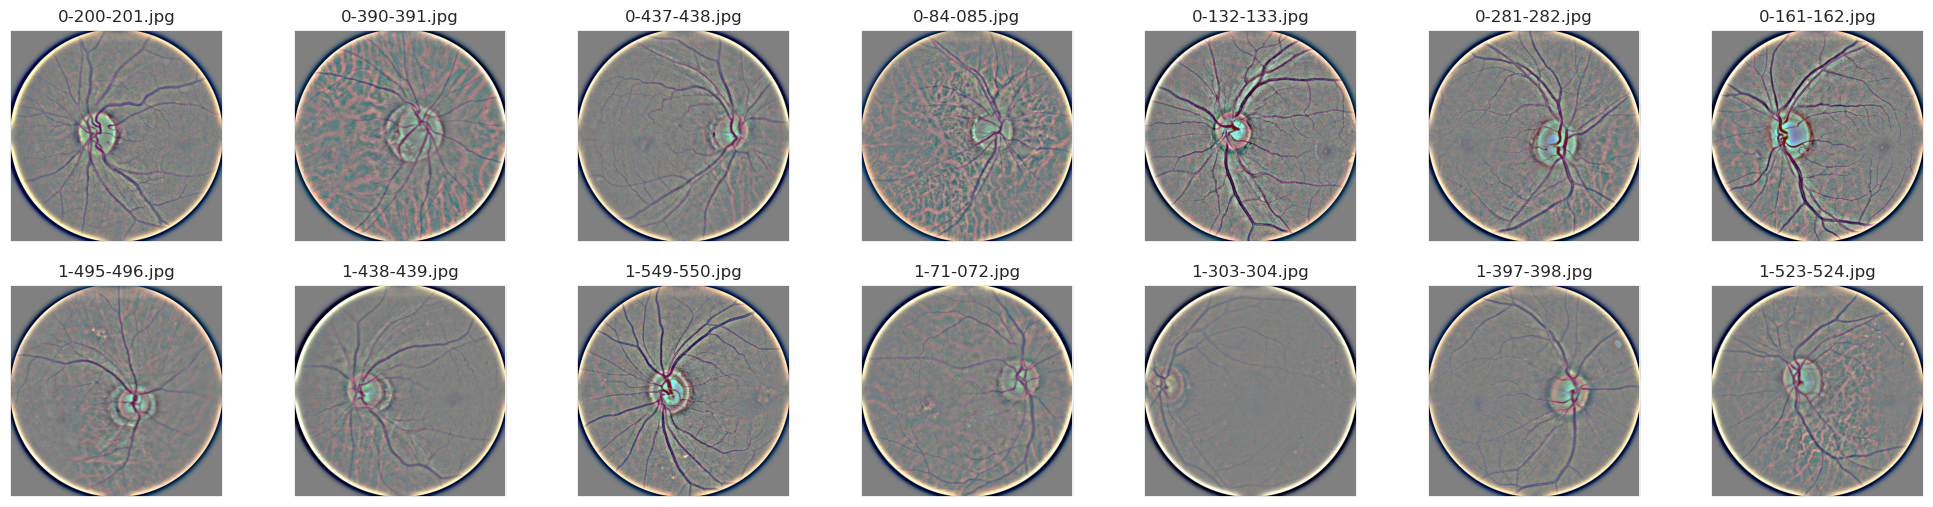

In [34]:
%%time
## try circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(df_train["Glaucoma"].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['Glaucoma'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"{row['image_file']}"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['Filename']) )

CPU times: user 15.6 s, sys: 614 ms, total: 16.2 s
Wall time: 8.11 s


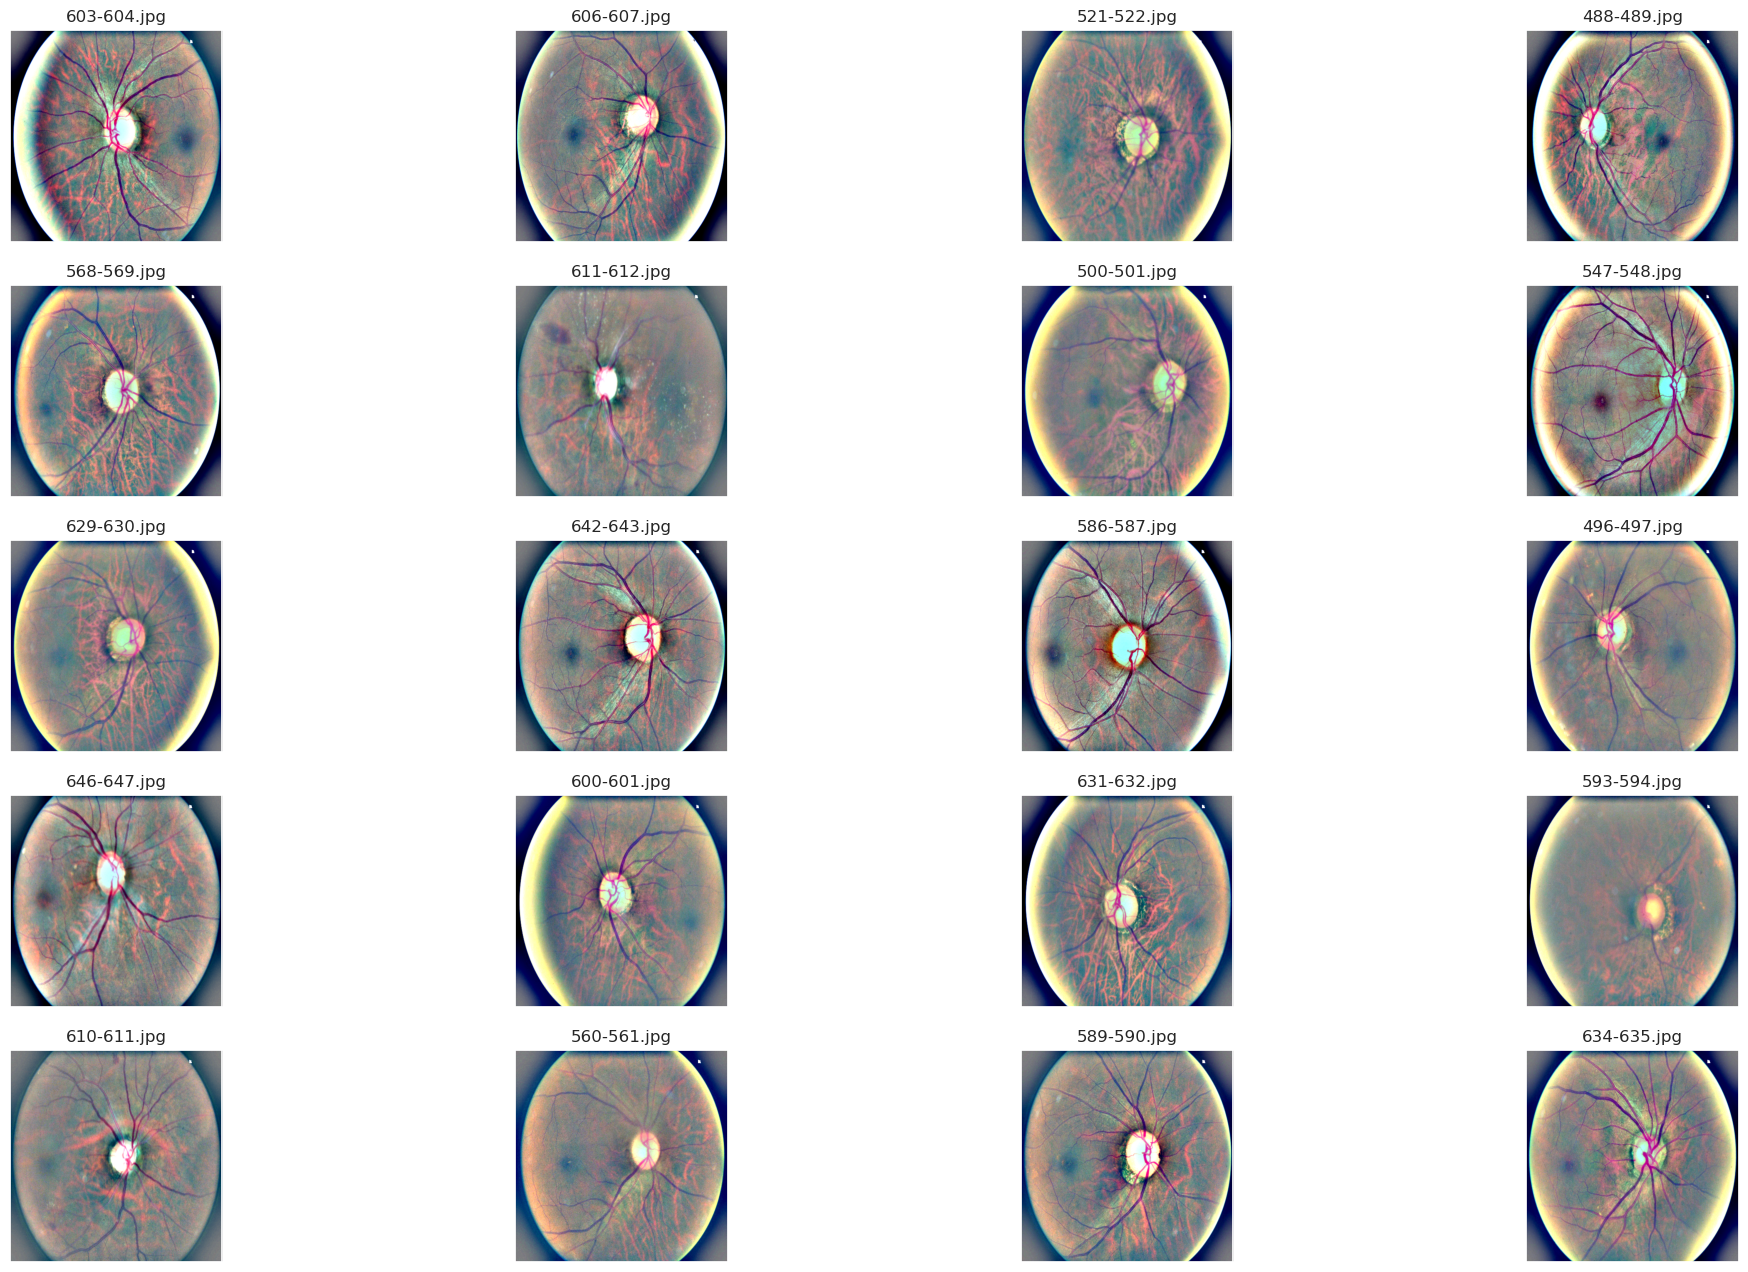

In [35]:
%%time
NUM_SAMP=4
fig = plt.figure(figsize=(25, 16))
for jj in range(5):
    for i, (idx, row) in enumerate(df_test.sample(NUM_SAMP,random_state=SEED+jj).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"{row['image_file']}"
        image = load_ben_color(path,sigmaX=30)
        
        plt.imshow(image)
        ax.set_title('%d-%s' % (idx, row['Filename']) )

# CNN

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess the data

X_train = []
y_train = []

for i in range(len(df_train)):
    image_path = df_train['image_file'][i]
    label = df_train['Glaucoma'][i]
    
    # Preprocess the image using load_ben_color function
    image = load_ben_color(image_path)
    
    X_train.append(image)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train the model

model.fit(X_train, y_train, epochs=10, batch_size=32)






KeyError: 482